# Work description

CentraleSupélec - Unicersité Paris-Saclay

ST4 - Resilience

__EDF Project - 10/06/2022__

GROUP 7

         Ana Luiza HAAS BEZERRA     ana-luiza.bezerra@student-cs.fr

         Klaus HOLLER               klaus.holler@student-cs.fr

         Lucas FONSECA PITTA        lucas.fonseca-pitta@student-cs.fr
         
         Lawson OLIVEIRA LIMA       lawson.oliveira@student-cs.fr

In this booklet we present the steps and procedures adopted to determine the ideal size of a dam in order to protect a industrial facility located in the berge of a river from possible flooding.

According to the project description, three different approaches are analyzed.

All decisions made and results obtained are discussed in their respective places.

# 1. First approach

Determination of the dike height from historical measurements

* Import libraries

In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
#from sympy import Symbol
import copy as cp
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sympy import Symbol
from scipy.linalg import cholesky
from math import sqrt
import warnings
warnings.filterwarnings('ignore')


* Read dataset

In [320]:
data=pd.read_excel("./Dataset/Flow_history.xls")
data=pd.DataFrame(np.array(data),columns=['Year','Flow','Height'])

# Data with all year/flow/height (height=NaN included)
data["Year"]=data["Year"].to_numpy().astype(int)
data_year= data["Year"].to_numpy().astype(int)
data_flow = data["Flow"].to_numpy()
data_height = data["Height"].to_numpy()

# Data with all year/flow/height (height=NaN not included)
data2 = data.dropna(axis='rows')
data2["Year"]=data2["Year"].to_numpy().astype(int)
data_year2= data2["Year"].to_numpy().astype(int)
data_flow2= data2["Flow"].to_numpy()
data_height2 = data2["Height"].to_numpy()
print(data.describe())


              Year         Flow      Height
count   149.000000   149.000000  123.000000
mean   1923.000000  1335.419913    3.896748
std      43.156691   713.926746    1.272337
min    1849.000000   122.435600    1.000000
25%    1886.000000   799.918835    3.100000
50%    1923.000000  1256.402143    3.900000
75%    1960.000000  1694.929723    4.750000
max    1997.000000  3853.892756    7.200000


### 1.1 Data visualisation

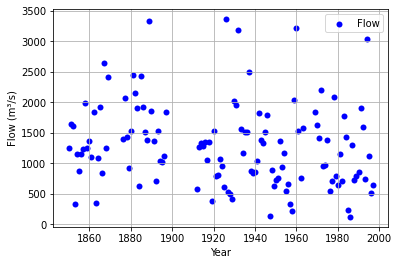

In [321]:
#plot year vs flow data without Nan
plt.figure()
plt.scatter(data_year2, data_flow2, color="blue", label="Flow",linewidths=0.0001)
plt.legend()
plt.grid(axis="both")
plt.xlabel("Year")
plt.ylabel("Flow (m³/s)")
plt.show()

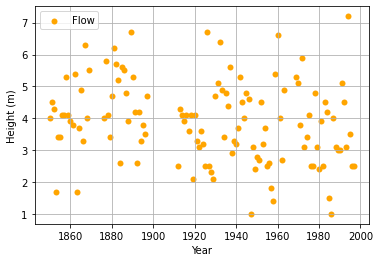

In [322]:
#plot year vs height data without Nan
plt.figure()
plt.scatter(data_year2, data_height2, color="orange", label="Flow",linewidths=0.0001)
plt.legend()
plt.grid(axis="both")
plt.xlabel("Year")
plt.ylabel("Height (m)")
plt.show()

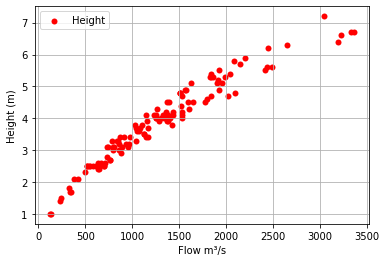

In [323]:
#plot height vs flow data without Nan
plt.figure()
plt.scatter(data_flow2, data_height2, color="red", label="Height",linewidths=0.0001)
plt.grid(axis="both")
plt.xlabel("Flow m³/s")
plt.ylabel("Height (m)")
plt.legend()
plt.show()

### 1.2 Determining missing heights

For this method we use the __polynomial regression__ of 2nd degree to estimate the missing data.

* Model

In [324]:
degree=2
model=make_pipeline(PolynomialFeatures(degree),LinearRegression())

# Training data and fitting model
x_train, x_test, y_train, y_test = train_test_split(data_flow2, data_height2, test_size=0.2, random_state=40)
x_train=x_train.reshape((-1,1))
x_test=x_test.reshape((-1,1))
model.fit(x_train,y_train)

y_pred = model.predict(x_test)

* Estimate error

In [325]:
# Root Mean Squared Deviation
rmsd = np.sqrt(mean_squared_error(y_test, y_pred))      
r2_value = r2_score(y_test, y_pred)                     

print("Root Mean Square Error:\n", rmsd)
print("R^2 Value:\n", r2_value)

Root Mean Square Error:
 0.21994625839272286
R^2 Value:
 0.9690688257154997


* Plot error of test set

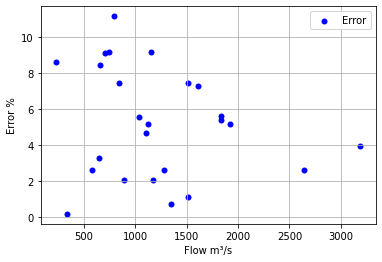

In [326]:
#Predict the output
error=abs(y_pred-y_test)

#Plot
plt.figure()
plt.scatter(x_test, 100*abs(y_pred-y_test)/y_test, color="blue", label="Error",linewidths=0.0001)
plt.grid(axis="both")
plt.xlabel("Flow m³/s")
plt.ylabel("Error %")
plt.legend()
plt.show()

* Determing missing data by polynomial regression

In [327]:
Years=np.linspace(np.min(data_year),np.max(data_year),num=((np.max(data_year)-np.min(data_year)+1))).astype(int)
Flow=cp.deepcopy(data_flow)
Height=[]
for i in Years:
    if  i not in data_year2:
        Height.append(model.predict(data_flow[i-np.min(data_year)].reshape((-1,1)))[0])
    else:
        Height.append(data_height[i-np.min(data_year)])

* Plot height set with estimated heights

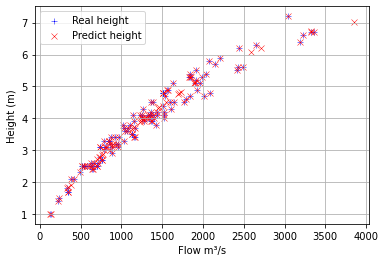

In [328]:
plt.figure()
plt.scatter(data_flow2, data_height2,marker='+',color="blue", label="Real height",linewidths=0.5)
plt.grid(axis="both")
plt.xlabel("Flow m³/s")
plt.ylabel("Height (m)")
plt.scatter(Flow, Height, marker='x',color="red", label="Predict height",linewidths=0.5)
plt.legend()
plt.show()

### 1.3 Histogram

Visualisation of the data __histogram__ with and without the estimated missing data.

Kernel density function __(KDE)__ plotted for visualisation.


Fonction to plot histograms

In [329]:
def plot_histogram(X,axes,label_axes,colors,dist=[],label_dist=[],points=[]):
    if axes[0]==1 and axes[1]==1:
        fig, ax = plt.subplots(1,axes[1],figsize=(12,5))
        sns.distplot(X,ax=ax,color=colors[0],kde_kws={"color": "k", "lw": 0.5, "label": "KDE"})            
        if len(dist)!=0:
            ax.plot(points,dist[0],lw=2,label=label_dist[0])            
        ax.set_yticks([])
        ax.set_xlabel(label_axes[0])
        #ax.legend()
        plt.show()
    elif axes[0]!=1:
        fig, ax = plt.subplots(axes[0],axes[1],figsize=(15,8))
        for i in range(axes[0]):
            for j in range(axes[1]):
                sns.distplot(X[i],ax=ax[i][j],color=colors[i+j],kde_kws={"color": "k", "lw": 0.5})
                if len(dist)!=0:
                    ax[i][j].plot(points,dist[i+j],lw=2,label=label_dist[i+j])
                ax[i][j].set_xlabel(label_axes[i+j])
                ax[i][j].set_yticks([])
                #ax[i][j].legend()
        plt.show()
    elif axes[0]==1:
        fig, ax = plt.subplots(1,axes[1],figsize=(12,5))
        for i in range(axes[1]):
            sns.distplot(X[i],ax=ax[i],color=colors[i],kde_kws={"color": "k", "lw": 0.5, "label": "KDE"})            
            if len(dist)!=0:
                ax[i].plot(points,dist[i],lw=2,label=label_dist[i])            
            ax[i].set_yticks([])
            ax[i].set_xlabel(label_axes[i])
            #ax[i].legend()
        plt.show()
    else:
        print("Dimensional error")

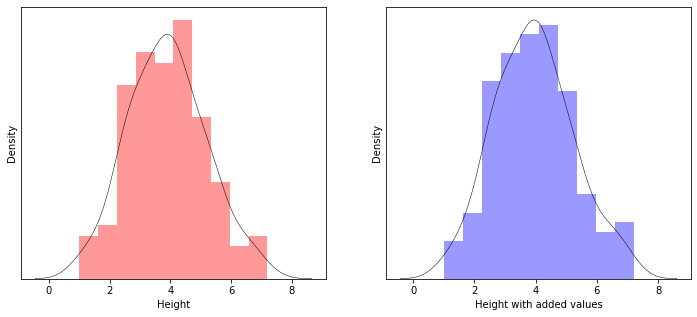

In [330]:
plot_histogram([data_height2,Height],[1,2],['Height','Height with added values'],['r','b'])

### 1.4 Fitting distribution to the dataset

In this section __Weibull__, **Gumbel** and __Normal__ (Gaussian) distributions are fitted for the dataset.

For each distribution the __p-value__ is obtained using the __chi-2__ method, which is useful to validate if a parametric distribution can or cannot be used to explain a dataset. The __square error__ is also calculated.

In [331]:
emp_mean = np.mean(Height)
emp_stand_dev = np.std(Height)

#Tx = constant of the rejection region from the chi-2 test
Tx=[0,0,0] 
errors=[0,0,0]

#P-value and error of normal distribution using chi-2
n=15
df=n-2-1

hist_values = np.linspace(0.9,7.7,n)
hist_norm_cdf = scp.stats.norm.cdf(hist_values,loc=emp_mean,scale=emp_stand_dev)
hist = np.zeros(n)

hist_norm = np.zeros(n)
for i in range(len(hist_values)-1):
    hist[i]=np.count_nonzero((Height<hist_values[i+1]) & (Height>=hist_values[i]))
    hist_norm[i]=(hist_norm_cdf[i+1]-hist_norm_cdf[i])*149
    Tx[0] += (hist[i]-hist_norm[i])**2/hist_norm[i]
    errors[0]+=(hist[i]-hist_norm[i])**2

#P-value and error of Weibull distribution using chi-2
weibull_cste = scp.stats.weibull_min.fit(Height)
hist_wei_cdf = scp.stats.weibull_min.cdf(hist_values,weibull_cste[0],weibull_cste[1],weibull_cste[2])
hist2 = np.zeros(n)
hist_wei = np.zeros(n)
for i in range(len(hist_values)-1):
    hist2[i]=np.count_nonzero((Height<hist_values[i+1]) & (Height>=hist_values[i]))
    hist_wei[i]=(hist_wei_cdf[i+1]-hist_wei_cdf[i])*149
    Tx[1] += (hist2[i]-hist_wei[i])**2/hist_wei[i]
    errors[1] += (hist2[i]-hist_wei[i])**2

#P-value and error of Gumbel distribution using chi-2
gumbel_cste = scp.stats.gumbel_r.fit(Height)
hist_gum_cdf = scp.stats.gumbel_r.cdf(hist_values,gumbel_cste[0],gumbel_cste[1])
hist3 = np.zeros(n)
hist_gum = np.zeros(n)
for i in range(len(hist_values)-1):
    hist3[i]=np.count_nonzero((Height<hist_values[i+1]) & (Height>=hist_values[i]))
    hist_gum[i]=(hist_gum_cdf[i+1]-hist_gum_cdf[i])*149
    Tx[2] += (hist3[i]-hist_gum[i])**2/hist_gum[i]
    errors[2] += (hist3[i]-hist_gum[i])**2

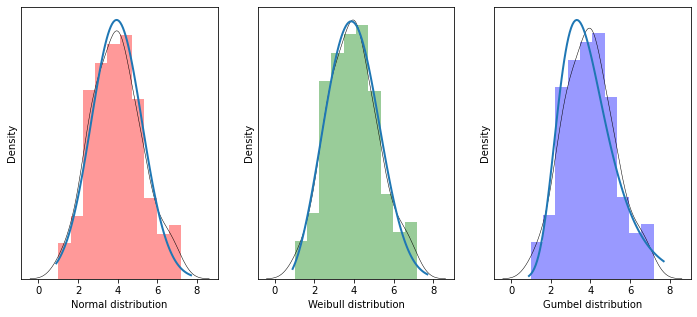

P-value - normal distribution: 0.4145942921111919
          Weibull distribution: 0.36992470653654486
          Gumbel distribution: 0.6419136297156044
Square error - normal distribution: 118.80468345382576
               Weibull distribution: 111.2205176082584
               Gumbel distribution: 152.3372673294128


In [332]:
x=np.linspace(0.9,7.7,100)
plot_histogram([Height]*3,[1,3],['Normal distribution','Weibull distribution','Gumbel distribution'],['r','g','b'],[scp.stats.norm.pdf(x,emp_mean,emp_stand_dev),scp.stats.weibull_min.pdf(x,weibull_cste[0],weibull_cste[1],weibull_cste[2]),scp.stats.gumbel_r.pdf(x,gumbel_cste[0],gumbel_cste[1])],['Normal','Weibull','Gumbel'],x)

#Print errors and p-values
print('P-value - normal distribution:', 1-scp.stats.chi2.cdf(df,Tx[0]))
print('          Weibull distribution:', 1-scp.stats.chi2.cdf(df-1,Tx[1]))
print('          Gumbel distribution:', 1-scp.stats.chi2.cdf(df,Tx[2]))
print('Square error - normal distribution:', errors[0])
print('               Weibull distribution:', errors[1])
print('               Gumbel distribution:', errors[2])


### 1.4 Determination of the dike height based on the chosed distribution

From the previous step we verify that all three distributions can describe the dataset. With an __hypothesis test__ it's clear that the p-value for all of them is high enough to keep the null hypothesis (the distribution represents the database), thus __no strong conclusion__ can be obtained from it. A valid comment is that the Gumbel distribution is the one with highest p-value, therefore the most unlikely to be discarded.

In order to obtain a stronger conclusion the square error is more adequate as an indicator of the distributions performance regarding the database. Through this procedure the Weibull distribution outstands with a lower error compared to the other distributions. Yet, this indicator still doesn't show a strong evidence of rejection for the other distributions, as the errors are on the same order of magnitude.

Taking in consideration the discussion above the __chosed distribution is Weibull__ due to its lower square error.

In this section the __quantiles of 0.95 and 0.99__ are used to determine the safety level of a dike with respect to the height of the water. This is a __Value-at-Risk (Var)__ approach.

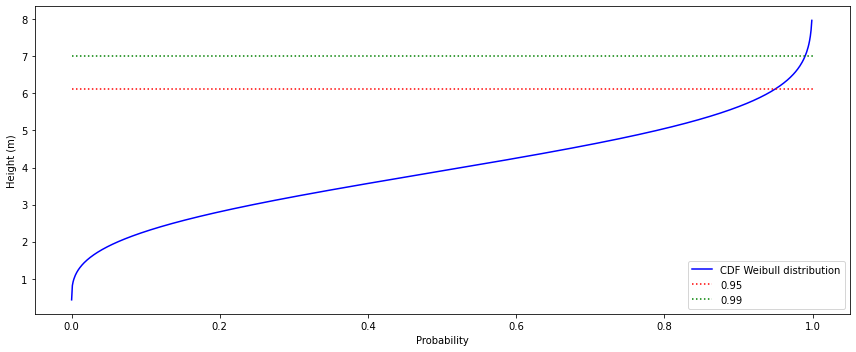

Water height for quantile 0.95: 6.1231242155636725 m
Water height for quantile 0.99: 7.009061497513449 m


In [333]:
# Plot Wiebull CDF and the chosen quantiles
y = np.linspace(0,1,1000)
plt.figure(figsize=(12,5))
plt.plot(y,scp.stats.weibull_min.ppf(y,weibull_cste[0],weibull_cste[1],weibull_cste[2]),'b',label = 'CDF Weibull distribution')
plt.plot(np.array([0, 1]), (np.array([1,1])*scp.stats.weibull_min.ppf(0.95,weibull_cste[0],weibull_cste[1],weibull_cste[2])),':r',label='0.95')
plt.plot(np.array([0, 1]), (np.array([1,1])*scp.stats.weibull_min.ppf(0.99,weibull_cste[0],weibull_cste[1],weibull_cste[2])),':g',label='0.99')
plt.xlabel('Probability')
plt.ylabel('Height (m)')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate the dike height for each quantile
print('Water height for quantile 0.95:', scp.stats.weibull_min.ppf(0.95,weibull_cste[0],weibull_cste[1],weibull_cste[2]), 'm')
print('Water height for quantile 0.99:', scp.stats.weibull_min.ppf(0.99,weibull_cste[0],weibull_cste[1],weibull_cste[2]), 'm')

### 1.5 Conclusion for the first approach

Based on the steps described above it can be said that a dike __hd = 6.12 m__ will prevent with 95% certainty the risk of flooding and a __hd = 7.01 m__ can prevent with 99% of certainty the risk of flooding. This information only takes in consideration the height of the water, not the terrain elevation.

Taking the terrain parameters in consideration we have the following equation:

__hb = H + Zv - Zb__

Where:

Zb (shoreline elevation) = 55.5 m (deterministic)

Zv (Downstream watercourse bottom elevation) = 50 m (average value of the random variable)


Based in this equation we have the following values for the dike height:

__hb = 0.62 m__ with 95% of certainty of no flooding

__hb = 1.5 m__ with 99% of certainty of no flooding

# 2. Second Approach

In this approch, the objectif is to use the modeling equation (1) of $H$, the water level of the watercourse, in order to minimize the overflow height, $S$, that is related to the physical variables and the height of the dike by the equation (2).

$H = {\left(\frac{Q}{K_s \sqrt(\frac{Z_m - Z_v}{L}) B}\right)}^{\frac{3}{5}} \ (1)$

$S = Z_c - Z_d = Zv + H - \mathcal{H}_d - Z_b \ (2) $

By the formulation of the problem, the major sources of uncertainty are considered to be the variables $Q$, $Z_m$, $Z_v$ and $K_s$. In this sense these variables are considered to be random variables with the following distributions :

$Q \sim Gumbel(1013, 558)$

$Z_m \sim Triangular(55, halfrange = 1)$

$Z_v \sim Triangular(50, halfrange = 1)$

$K_s \sim \mathcal{N}(30, 7.5)$

The other variables, $B$, $L$ and $Z_b$, are considered to be deterministics with values 300, 5000 and 55,5 respectively.

For the development that follows, it will be considered majorly the first scenario proposed in the project in which the random variables aren't correlated

-----

2.1) In this block it's generated 1 million samples of the random variables for the scenario when the random variables are independent.

It was considered that it doesn't make sense to have negative values of $Q$ and $K_s$ analysing their physical meaning in the model. But these variables follows porbabilistic laws that allows negative realisations. To solve this issue, when negative realisations of these variables occur, they are repeated until an positive values is obtained.

In [334]:
def PosNormal(mean, sigma):
    x = np.random.normal(mean,sigma)
    return(x if x>=0 else PosNormal(mean,sigma))

def PosGumbel(mode, scale):
    x = np.random.gumbel(mode,scale)
    return(x if x>=0 else PosGumbel(mode,scale))

#n_sub_samples=len(Height)
def generate_sample(n=1000000):
    sample=[]
    Q_a=np.array([PosGumbel(1013,558) for i in range(n)])
    k_sa=np.array([PosNormal(30,7.5) for i in range(n)])
    Z_va=np.array([np.random.triangular(49,50,51) for i in range(n)])
    Z_ma=np.array([np.random.triangular(54,55,56) for i in range(n)])
    sample=np.array([Q_a,k_sa,Z_va,Z_ma])
    return sample

In [335]:
n_sample=1000000
sample=generate_sample(n_sample)

#first scenario
q_realisations = sample[0]
ks_realisations = sample[1]
zv_realisations = sample[2]
zm_realisations = sample[3]

2.2) Plot histogram to first case

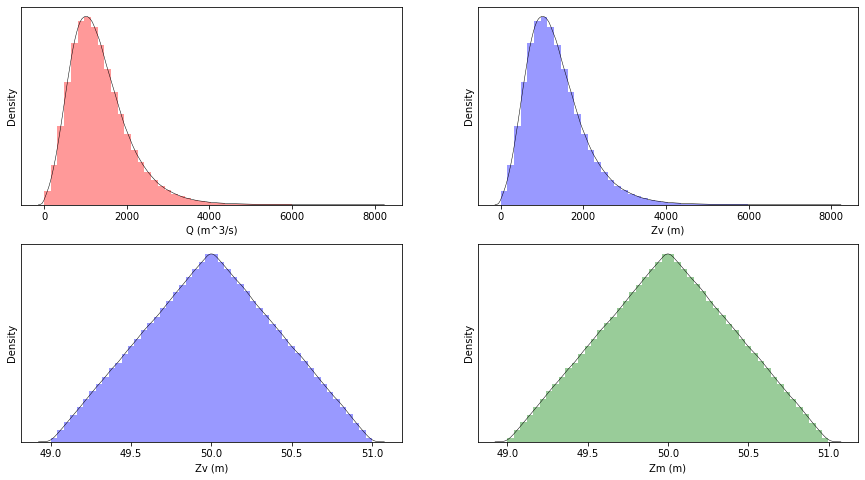

In [336]:
plot_histogram([q_realisations,zv_realisations,zm_realisations,ks_realisations],[2,2],label_axes=['Q (m^3/s)','Zv (m)','Zm (m)','Ks(m)',],colors=['r','b','g','y'])

2.3) In this block it's generated the equivalent H and S related to the samples of $Q$, $K_s$, $Z_m$ and $Z_v$ using the equations (1) and (2) and their histogram is shown. S represents the overflow in the facility and, to be able to model the height of the dike, we consider first $\mathcal{H}_d = 0$.

In [337]:
cut=0.99 # Just to plot histogram

def generate_s_sample(sample:list,B=300,L=5000,Zb=55.5,hd=0):
    Q,Ks,Zv,Zm=sample[0],sample[1],sample[2],sample[3]
    strike_coef=np.power(np.multiply(Q,1/(B*np.multiply(Ks,np.sqrt((Zm-Zv)/L)))),3/5) 
    S=Zv+strike_coef+hd-Zb 
    return S, strike_coef

In [338]:
first_scenario=[q_realisations,ks_realisations,zv_realisations,zm_realisations]
first_scenario, strike_coef1=generate_s_sample(first_scenario)
first_scenario,strike_coef1=np.sort(first_scenario),np.sort(strike_coef1)
first_scenario,strike_coef1=np.delete(first_scenario,np.isnan(first_scenario)),np.delete(strike_coef1,np.isnan(strike_coef1))

2.3.1) Plot histogram of the strike coeficient and the overflow for the first case

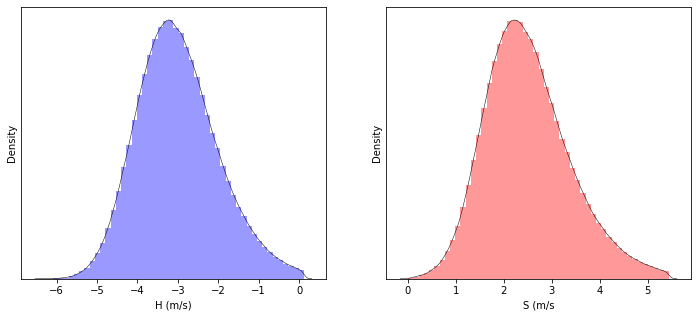

In [339]:
plot_histogram([first_scenario[0:int(len(strike_coef1)*cut)],strike_coef1[0:int(len(strike_coef1)*cut)]],[1,2],label_axes=['H (m/s)', 'S (m/s'],colors=['b','r'])

2.4) To be able to determine a parametric distribution for S in the first scenario, an Hypothesis test is carried for 3 candidates : Weibull, Gumbel and Exponential. The parameters for the 3 distributions are calculated by fitting function in the scipy.stats library.

This hypothesis test analyses if the parametric distribution represents the distribution of dataset. In this step we are able to determinate an $\mathcal{H}_d$ correspondent to 3 different quantiles, 99.99%, 99.8% and 99.5%. The quantiles are computed using both the empirical distribution and the deduced parametric distribution. It's used the $\chi^2$ hypothesis test and the most appropriate parametric distribution is chosen by the comparison of the quadratic error.

Before implementing the fitting of the parametric law of S, the values of S are filtered to maintain only the positive values using the function delete_neg. As the negative values represents that there is no overflow and that the facility is safe, this manipulation is useful to properly describe the phenomena of interest.

In [340]:
quantil1=0.9999
quantil2=0.998
quantil3=0.995

first_scenario = first_scenario[first_scenario >= 0]
emp_mean = np.mean(first_scenario)
emp_stand_dev = np.std(first_scenario)

#computing the pvalue for the normal distribution using the chi2 test
n=100
df=n-2-1
hist_values = np.zeros(n)
for i in range(n):
    hist_values[i] = np.exp(np.log(11)*(i/n)**2)-1
    
# Computing the pvalue for the exponential distribution using the chi2 test
expon_cste = scp.stats.expon.fit(first_scenario)
hist_exp_cdf = scp.stats.expon.cdf(hist_values,expon_cste[0],expon_cste[1])
hist = np.zeros(n)
Tx = 0
erro = 0
hist_exp = np.zeros(n)

for i in range(len(hist_values)-1):
    hist[i]=np.count_nonzero((first_scenario<hist_values[i+1]) & (first_scenario>=hist_values[i]))
    hist_exp[i]=(hist_exp_cdf[i+1]-hist_exp_cdf[i])*len(first_scenario)
    Tx += (hist[i]-hist_exp[i])**2/hist_exp[i]
    erro+=(hist[i]-hist_exp[i])**2
print('p-value for exp(%s,%s) is %s' % (expon_cste[0],expon_cste[1],1-scp.stats.chi2.cdf(df,Tx)))
print('The quadratic error associated to the exponential distribution is %s' % erro) #quadratic error for the exponential distribution

# Computing the pvalue for the weibull distribution using the chi2 test
weibull_cste = scp.stats.weibull_min.fit(first_scenario)
hist_wei_cdf = scp.stats.weibull_min.cdf(hist_values,weibull_cste[0],weibull_cste[1],weibull_cste[2])
hist2 = np.zeros(n)
Tx2 = 0
erro2 = 0
hist_wei = np.zeros(n)
for i in range(len(hist_values)-1):
    hist2[i]=np.count_nonzero((first_scenario<hist_values[i+1]) & (first_scenario>=hist_values[i]))
    hist_wei[i]=(hist_wei_cdf[i+1]-hist_wei_cdf[i])*len(first_scenario)
    Tx2 += (hist2[i]-hist_wei[i])**2/hist_wei[i]
    erro2 += (hist2[i]-hist_wei[i])**2
    
print('\np-value for weibull(%s,%s) is %s' % (weibull_cste[0],weibull_cste[1],1-scp.stats.chi2.cdf(df-1,Tx2)))
print('The quadratic error associated to the weibull distribution is %s' % erro2) #quadratic error for the weibul distribution

# Computing the pvalue for the gumbel distribution using the chi2 test
gumbell_cste = scp.stats.gumbel_r.fit(first_scenario)
hist_gum_cdf = scp.stats.gumbel_r.cdf(hist_values,gumbell_cste[0],gumbell_cste[1])
hist3 = np.zeros(n)
Tx3 = 0
erro3 = 0
hist_gum = np.zeros(n)
for i in range(len(hist_values)-1):
    hist3[i]=np.count_nonzero((first_scenario<hist_values[i+1]) & (first_scenario>=hist_values[i]))
    hist_gum[i]=(hist_gum_cdf[i+1]-hist_gum_cdf[i])*len(first_scenario)
    Tx3 += (hist3[i]-hist_gum[i])**2/hist_gum[i]
    erro3 += (hist3[i]-hist_gum[i])**2

print('\np-value for gumbell(%s,%s) is %s' % (gumbell_cste[0],gumbell_cste[1],1-scp.stats.chi2.cdf(df,Tx3)))
print('The quadratic error associated to the gumbell distribution is %s' % erro3) #quadratic error for the gumbel distribution

p-value for exp(2.1447669212193432e-05,0.9731547360816041) is 1.0
The quadratic error associated to the exponential distribution is 55830.04553003175

p-value for weibull(0.8319426674284753,2.1447669212193425e-05) is 1.0
The quadratic error associated to the weibull distribution is 48532.966488912425

p-value for gumbell(0.5197168146076498,0.6292753881491921) is 1.0
The quadratic error associated to the gumbell distribution is 302677.4484353259

The chosen Hd from the empirical distribution is 121.1807214483169
The parametric distribution with less error is weibull and the chosen Hd from the deduced parametric distribution is : 14.423335594084683


By the analysis of the p-values it's not possible to exclude any distribution. Therefore, the parametric distribution is an Weibull chosen by the quadratic error. Proceeding to compute the equivalent $\mathcal{H}_d$ and to plot the histograms of S with the considered distributions:

In [ ]:
h_d_empirical1 = np.quantile(first_scenario,quantil1)
h_d_empirical2 = np.quantile(first_scenario,quantil2)
h_d_empirical3 = np.quantile(first_scenario,quantil3)
print('Quantile 99,99%' + ': Hd_empirical = %s' % h_d_empirical1)
print('Quantile 99,8%' +': Hd_empirical = %s' % h_d_empirical2)
print('Quantile 99,5%'+ ': Hd_empirical = %s' % h_d_empirical3)

if erro <= erro2 and erro <= erro3:
    h_d1 = scp.stats.expon.ppf(quantil1,expon_cste[0],expon_cste[1])
    h_d2 = scp.stats.expon.ppf(quantil2,expon_cste[0],expon_cste[1])
    h_d3 = scp.stats.expon.ppf(quantil3,expon_cste[0],expon_cste[1])
    print('The parametric distribution with less error is exponential')
    print('Quantile 99,99%' + ':Hd_distribution = %s' % h_d1)
    print('Quantile 99,8%' + ': Hd_distribution = %s' % h_d2)
    print('Quantile 99,5%' + ': Hd_distribution = %s' % h_d3)

elif erro2 <= erro and erro2 <=erro3:
    h_d1 = scp.stats.weibull_min.ppf(quantil1,weibull_cste[0],weibull_cste[1])
    h_d2 = scp.stats.weibull_min.ppf(quantil2,weibull_cste[0],weibull_cste[1])
    h_d3 = scp.stats.weibull_min.ppf(quantil3,weibull_cste[0],weibull_cste[1])
    print('The parametric distribution with less error is weibull')
    print('Quantile 99,99%' + ': Hd_distribution = %s' % h_d1)
    print('Quantile 99,8%' + ': Hd_distribution = %s' % h_d2)
    print('Quantile 99,5%' + ': Hd_distribution = %s' % h_d3)
else:
    h_d1 = scp.stats.gumbel_r.ppf(quantil1,gumbell_cste[0],gumbell_cste[1])
    h_d2 = scp.stats.gumbel_r.ppf(quantil2,gumbell_cste[0],gumbell_cste[1])
    h_d3 = scp.stats.gumbel_r.ppf(quantil3,gumbell_cste[0],gumbell_cste[1])
    print('The parametric distribution with less error is gumbel')
    print('Quantile 99,99%' + ': Hd_distribution = %s' % h_d1)
    print('Quantile 99,8%' + ': Hd_distribution = %s' % h_d2)
    print('Quantile 99,5%' +': Hd_distribution = %s' % h_d3)

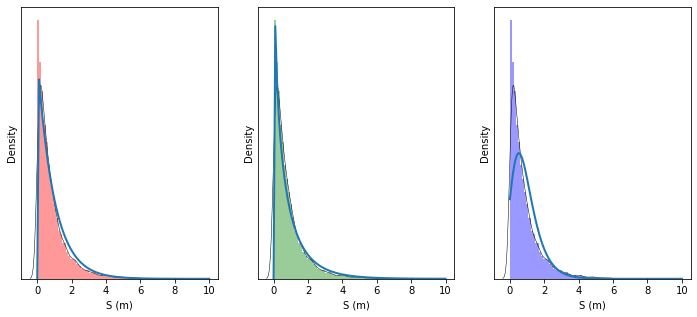

In [341]:
# Plotting the histograms to undestand the comparison between the fitted distributions and the empirical one
points=np.linspace(0,10,100)
dist=[scp.stats.expon.pdf(points,expon_cste[0],expon_cste[1]),scp.stats.weibull_min.pdf(points,weibull_cste[0],weibull_cste[1],weibull_cste[2]),scp.stats.gumbel_r.pdf(points,gumbell_cste[0],gumbell_cste[1])]
plot_histogram([first_scenario[0:int(len(first_scenario)*cut)]]*3,[1,3],['S (m)','S (m)','S (m)'],['r','g','b'],dist,['Exp','Weibull','Gunbell'],points)

2.5) In the previous steps, it was considered one simulation of 1 million samples to chose $\mathcal{H}_d$. But the choosen height of the dike is sensitive to the data used. To solve this issue, in the following development it's generated 1000 simulations with 1 million samples each. From this , we are able to deduce the distribution of the height of the dike $\mathcal{H}_d$ and make a better conclusion of the height of the dike and analyse its sensibility using a confidence interval.

It's important to highlight that, in this part, we do not consider the empirical distribution from the hypothesis test analysis. Instead, the parametric distribution computed before is considered to be appropriate to determine $\mathcal{H}_d$ for all simulations.

In [342]:
n_simulations = 10
n_sample = 1000000

#function that compute the vector h_d of the chosen height of the dike for N_sim simulations
def multiple_simulations_parametric(n_simulations,quantil,n_sample=1000000):
    S = np.zeros(n_sample)
    h_d = np.zeros(n_simulations)
    for i in range(n_simulations):
        print("Progress: ",(i+1)/n_simulations*100,"%")
        sample = generate_sample(n_sample)
        S,strike_coef = generate_s_sample([sample[0],sample[1],sample[2],sample[3]])
        S = np.sort(S)
        S = S[S>0]
        S=np.delete(S,np.isnan(S))
        weibull_cste = scp.stats.weibull_min.fit(S)
        h_d[i][0] = scp.stats.weibull_min.ppf(quantil[0],weibull_cste[0],weibull_cste[1])
        h_d[i][1] = scp.stats.weibull_min.ppf(quantil[1],weibull_cste[0],weibull_cste[1])
        h_d[i][2] = scp.stats.weibull_min.ppf(quantil[2],weibull_cste[0],weibull_cste[1])
    return h_d

def multiple_simulations_empirical(n_simulations,quantil,n_sample=1000000):
    S = np.zeros(n_sample)
    h_d = np.zeros(n_simulations)
    for i in range(n_simulations):
        print("Progress: ",(i+1)/n_simulations*100,"%")
        sample = generate_sample(n_sample)
        S,strike_coef = generate_s_sample([sample[0],sample[1],sample[2],sample[3]])
        S = np.sort(S)
        S = S[S>0]
        S=np.delete(S,np.isnan(S))
        h_d[i][0] = np.quantile(S,quantil[0])
        h_d[i][1] = np.quantile(S,quantil[1])
        h_d[i][2] = np.quantile(S,quantil[2])
    return h_d

#generating the heights correspondent to the 1.000 simulations

h_d_distribution = multiple_simulations_parametric(n_simulations,[quantil1,quantil2,quantil3],n_sample=n_sample)


Progress:  0.1 %
Progress:  0.2 %
Progress:  0.3 %
Progress:  0.4 %
Progress:  0.5 %
Progress:  0.6 %
Progress:  0.7000000000000001 %


KeyboardInterrupt: 

Histogram of the $\mathcal{H}_d$ for a quantile of 99.99%. The confidence interval of 99% is also marked in the histogram and is $I_1 = [,]$

In [ ]:
#defining the confidence interval
Min_CI1 = np.quantile(h_d_distribution[0],0.005)
Max_CI1 = np.quantile(h_d_distribution[0],0.995)

#plotting the histogram of h_d for 1.000 simulations
fig = sns.distplot(h_d_distribution[0],color='b',kde_kws={"color": "k", "lw": 0.5},label = 'Histogram Hd')
plt.plot(np.array([1,1])*Min_CI1,np.array([0,fig.axes.get_ylim()[1]]),'r',\
         lw=3,label='Minimal limit of CI')
plt.plot(np.array([1,1])*Max_CI1,np.array([0,fig.axes.get_ylim()[1]]),'r',\
         lw=3,label='Maximal limit of CI')
plt.xlabel('$\mathcal{H}_d$ distribution, q=0.9999')
plt.legend()
plt.tight_layout()
plt.show()

Histogram of the $\mathcal{H}_d$ for a quantile of 99.8%. The confidence interval of 99% is also marked in the histogram and is $I_2 = [,]$

In [ ]:
#defining the confidence interval
Min_CI2 = np.quantile(h_d_distribution[1],0.005)
Max_CI2 = np.quantile(h_d_distribution[1],0.995)

#plotting the histogram of h_d for 1.000 simulations
fig = sns.distplot(h_d_distribution[1],color='b',kde_kws={"color": "k", "lw": 0.5},label = 'Histogram Hd')
plt.plot(np.array([1,1])*Min_CI2,np.array([0,fig.axes.get_ylim()[1]]),'r',\
         lw=3,label='Minimal limit of CI')
plt.plot(np.array([1,1])*Max_CI2,np.array([0,fig.axes.get_ylim()[1]]),'r',\
         lw=3,label='Maximal limit of CI')
plt.xlabel('$\mathcal{H}_d$ distribution,q=0.998')
plt.legend()
plt.tight_layout()
plt.show()

Histogram of the $\mathcal{H}_d$ for a quantile of 99.5%. The confidence interval of 99% is also marked in the histogram and is $I_2 = [,]$

In [ ]:
#defining the confidence interval
Min_CI3 = np.quantile(h_d_distribution[2],0.005)
Max_CI3 = np.quantile(h_d_distribution[2],0.995)

#plotting the histogram of h_d for 1.000 simulations
fig = sns.distplot(h_d_distribution[2],color='b',kde_kws={"color": "k", "lw": 0.5}, label = 'Histogram Hd')
plt.plot(np.array([1,1])*Min_CI3,np.array([0,fig.axes.get_ylim()[1]]),'r',\
         lw=3,label='Minimal limit of CI')
plt.plot(np.array([1,1])*Max_CI3,np.array([0,fig.axes.get_ylim()[1]]),'r',\
         lw=3,label='Maximal limit of CI')
plt.xlabel('$\mathcal{H}_d$ distribution, q =0.995')
plt.legend()
plt.tight_layout()
plt.show()

## Conclusion of the second approch

The analysis of the confidence interval of 99% for the height of the dike is important to undestand how this parameter is sensitive to the data by the use of different datasets.

The 99.99% quantile presents an confidence interval of $\mathcal{H}_d \in [,]$ that is larger then for the other 2 quantiles. This shows that using an risk averse mesure the equivalent $\mathcal{H}_d$ is significantly sensible to the dataset. The quantiles of 99.8% and 99.5% presents confidence intervals of $[,]$ and $[,]$ respectively.

However, the 99.99% quantile is the one that should be recommended when we consider the context and the consequences of a flood in an nuclear power plant. This analysis will be, of course, more clearly developped in the third approch that considers the cost of the flooding event and the cost of the construction of the dike.

In [ ]:
print("Dike height choosen is: ",np.mean(h_d_distribution[0]))

Dike height is:  18.13605695765212
